In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import pathlib
import tree as miptree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from model.threshold_guess import compute_thresholds, cut
from model.gosdt import GOSDT
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE
import datetime
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

In [2]:
# df_tran = pd.read_csv('transactions')
# maybe read as json like I do from the .txt file from Kaggle?
df_tran = pd.read_csv('transactions')

In [3]:
# This is unneeded if you upload as above

#df_tran = df_tran.drop(columns=['Unnamed: 0'])

In [4]:
df_tran

,Unnamed: 0,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,0,737265056,737265056,5000,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
1,1,737265056,737265056,5000,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,...,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
2,2,737265056,737265056,5000,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
3,3,737265056,737265056,5000,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
4,4,830329091,830329091,5000,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,...,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,786358,732852505,732852505,50000,48904.96,2016-12-22T18:44:12,119.92,Lyft,US,US,...,NaN,1095.04,NaN,NaN,NaN,False,NaN,NaN,False,False
786359,786359,732852505,732852505,50000,48785.04,2016-12-25T16:20:34,18.89,hulu.com,US,US,...,NaN,1214.96,NaN,NaN,NaN,False,NaN,NaN,False,False
786360,786360,732852505,732852505,50000,48766.15,2016-12-27T15:46:24,49.43,Lyft,US,US,...,NaN,1233.85,NaN,NaN,NaN,False,NaN,NaN,False,False
786361,786361,732852505,732852505,50000,48716.72,2016-12-29T00:30:55,49.89,walmart.com,US,US,...,NaN,1283.28,NaN,NaN,NaN,False,NaN,NaN,False,False


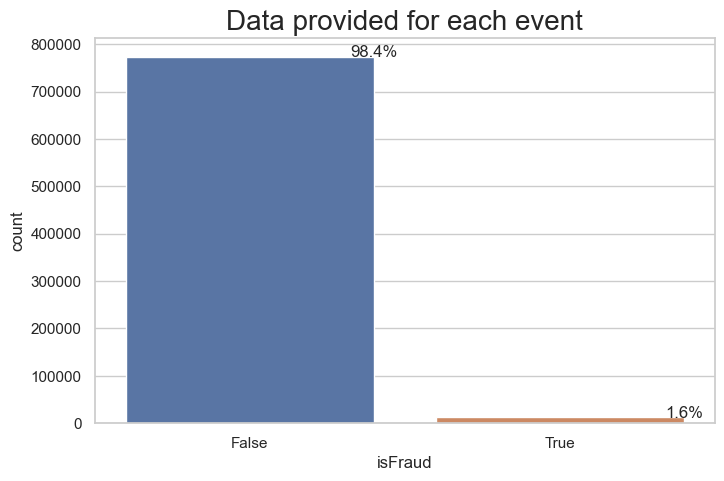

In [5]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
total = float(len(df_tran))
ax = sns.countplot(x="isFraud", data=df_tran)
plt.title('Data provided for each event', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

In [6]:
df_tran

,Unnamed: 0,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,0,737265056,737265056,5000,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
1,1,737265056,737265056,5000,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,...,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
2,2,737265056,737265056,5000,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
3,3,737265056,737265056,5000,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
4,4,830329091,830329091,5000,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,...,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,786358,732852505,732852505,50000,48904.96,2016-12-22T18:44:12,119.92,Lyft,US,US,...,NaN,1095.04,NaN,NaN,NaN,False,NaN,NaN,False,False
786359,786359,732852505,732852505,50000,48785.04,2016-12-25T16:20:34,18.89,hulu.com,US,US,...,NaN,1214.96,NaN,NaN,NaN,False,NaN,NaN,False,False
786360,786360,732852505,732852505,50000,48766.15,2016-12-27T15:46:24,49.43,Lyft,US,US,...,NaN,1233.85,NaN,NaN,NaN,False,NaN,NaN,False,False
786361,786361,732852505,732852505,50000,48716.72,2016-12-29T00:30:55,49.89,walmart.com,US,US,...,NaN,1283.28,NaN,NaN,NaN,False,NaN,NaN,False,False


### It can be seen that there are some features that have all rows as null so they need to be dropped

In [7]:
df_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                786363 non-null  int64  
 1   accountNumber             786363 non-null  int64  
 2   customerId                786363 non-null  int64  
 3   creditLimit               786363 non-null  int64  
 4   availableMoney            786363 non-null  float64
 5   transactionDateTime       786363 non-null  object 
 6   transactionAmount         786363 non-null  float64
 7   merchantName              786363 non-null  object 
 8   acqCountry                781801 non-null  object 
 9   merchantCountryCode       785639 non-null  object 
 10  posEntryMode              782309 non-null  float64
 11  posConditionCode          785954 non-null  float64
 12  merchantCategoryCode      786363 non-null  object 
 13  currentExpDate            786363 non-null  o

In [8]:
df_tran = df_tran.drop(columns=['echoBuffer','merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'])

### Removing features that are highly correlated

/var/folders/sn/1rkb9b6d6676rjdtm6y0sp880000gn/T/ipykernel_13932/2596127890.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_tran.corr(),cmap='coolwarm')


<AxesSubplot: >

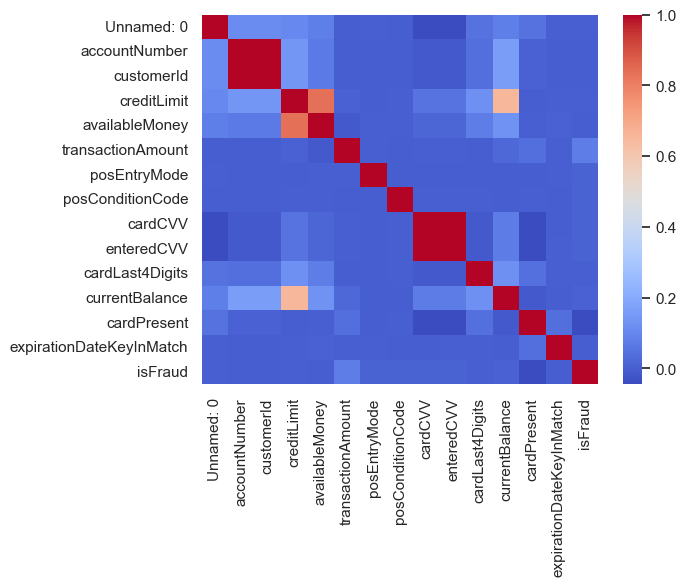

In [9]:
sns.heatmap(df_tran.corr(),cmap='coolwarm')

In [10]:
df_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                786363 non-null  int64  
 1   accountNumber             786363 non-null  int64  
 2   customerId                786363 non-null  int64  
 3   creditLimit               786363 non-null  int64  
 4   availableMoney            786363 non-null  float64
 5   transactionDateTime       786363 non-null  object 
 6   transactionAmount         786363 non-null  float64
 7   merchantName              786363 non-null  object 
 8   acqCountry                781801 non-null  object 
 9   merchantCountryCode       785639 non-null  object 
 10  posEntryMode              782309 non-null  float64
 11  posConditionCode          785954 non-null  float64
 12  merchantCategoryCode      786363 non-null  object 
 13  currentExpDate            786363 non-null  o

In [11]:
df_tran = df_tran.drop(['customerId','availableMoney','accountNumber','merchantName','cardLast4Digits'],axis=1)

/var/folders/sn/1rkb9b6d6676rjdtm6y0sp880000gn/T/ipykernel_13932/2596127890.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_tran.corr(),cmap='coolwarm')


<AxesSubplot: >

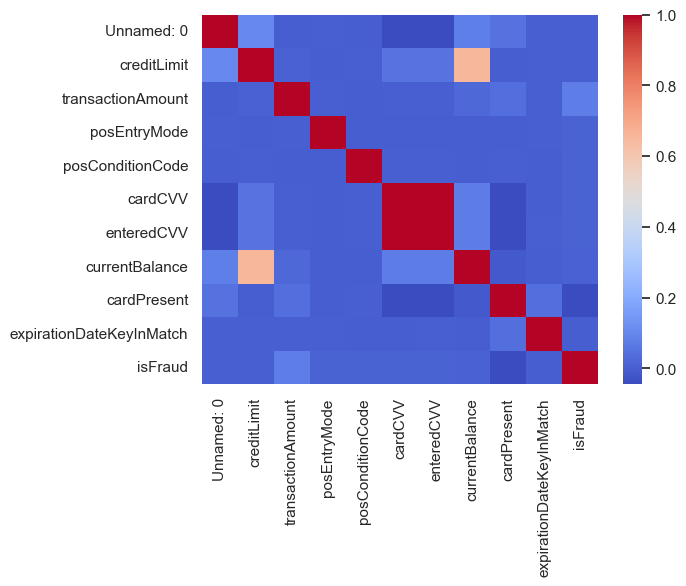

In [12]:
sns.heatmap(df_tran.corr(),cmap='coolwarm')

### Checking for unique values and doing some EDA

### accountNumber, last4digit, merchantName, Make a boolean feature to see if cardCVV matches the enteredCVV

In [13]:
for col in df_tran:
    print(f'{col}: {df_tran[col].nunique()}')

Unnamed: 0: 786363
creditLimit: 10
transactionDateTime: 776637
transactionAmount: 66038
acqCountry: 4
merchantCountryCode: 4
posEntryMode: 5
posConditionCode: 3
merchantCategoryCode: 19
currentExpDate: 165
accountOpenDate: 1820
dateOfLastAddressChange: 2184
cardCVV: 899
enteredCVV: 976
transactionType: 3
currentBalance: 487318
cardPresent: 2
expirationDateKeyInMatch: 2
isFraud: 2


In [14]:
df_tran['equalCVV'] = (df_tran['enteredCVV']==df_tran['cardCVV']).astype(int)

In [15]:
df_tran.equalCVV.value_counts()

1    779348
0      7015
Name: equalCVV, dtype: int64

In [16]:
df_tran = df_tran.drop(columns=['enteredCVV','cardCVV'])

In [17]:
import datetime

df_tran['transactionDateTime'] = pd.to_datetime(df_tran['transactionDateTime'])
df_tran['currentExpDate'] = pd.to_datetime(df_tran['currentExpDate'])
df_tran['accountOpenDate'] = pd.to_datetime(df_tran['accountOpenDate'])
df_tran['dateOfLastAddressChange'] = pd.to_datetime(df_tran['dateOfLastAddressChange'])

In [18]:
first_acc_date = df_tran.accountOpenDate.min()

In [19]:
### Converted date columns to numeric, however, this can also be explored later as making Separate columns for 
### different data columns by using this code

df_tran['transactionDateTime_year'] = df_tran['transactionDateTime'].dt.year
df_tran['transactionDateTime_month'] = df_tran['transactionDateTime'].dt.month
df_tran['transactionDateTime_day'] = df_tran['transactionDateTime'].dt.dayofweek
df_tran['transactionDateTime_hour'] = df_tran['transactionDateTime'].dt.hour
df_tran['transactionDateTime_minute'] = df_tran['transactionDateTime'].dt.minute
df_tran['transactionDateTime_second'] = df_tran['transactionDateTime'].dt.second

df_tran['currentExpDate_year'] = df_tran['currentExpDate'].dt.year
df_tran['currentExpDate_month'] = df_tran['currentExpDate'].dt.month
df_tran['currentExpDate_day'] = df_tran['currentExpDate'].dt.dayofweek

df_tran['accountOpenDate_year'] = df_tran['accountOpenDate'].dt.year
df_tran['accountOpenDate_month'] = df_tran['accountOpenDate'].dt.month
df_tran['accountOpenDate_day'] = df_tran['accountOpenDate'].dt.dayofweek

df_tran['dateOfLastAddressChange_year'] = df_tran['dateOfLastAddressChange'].dt.year
df_tran['dateOfLastAddressChange_month'] = df_tran['dateOfLastAddressChange'].dt.month
df_tran['dateOfLastAddressChange_day'] = df_tran['dateOfLastAddressChange'].dt.dayofweek

In [20]:
df_tran = df_tran.drop(columns=['transactionDateTime','currentExpDate','accountOpenDate','dateOfLastAddressChange'])

In [21]:
df_tran

,Unnamed: 0,creditLimit,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,...,transactionDateTime_second,currentExpDate_year,currentExpDate_month,currentExpDate_day,accountOpenDate_year,accountOpenDate_month,accountOpenDate_day,dateOfLastAddressChange_year,dateOfLastAddressChange_month,dateOfLastAddressChange_day
0,0,5000,98.55,US,US,2.0,1.0,rideshare,PURCHASE,0.00,...,32,2023,6,3,2015,3,5,2015,3,5
1,1,5000,74.51,US,US,9.0,1.0,entertainment,PURCHASE,0.00,...,54,2024,2,3,2015,3,5,2015,3,5
2,2,5000,7.47,US,US,9.0,1.0,mobileapps,PURCHASE,0.00,...,39,2025,8,4,2015,3,5,2015,3,5
3,3,5000,7.47,US,US,9.0,1.0,mobileapps,PURCHASE,0.00,...,50,2025,8,4,2015,3,5,2015,3,5
4,4,5000,71.18,US,US,2.0,1.0,fastfood,PURCHASE,0.00,...,46,2029,10,0,2015,8,3,2015,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,786358,50000,119.92,US,US,90.0,1.0,rideshare,PURCHASE,1095.04,...,12,2022,12,3,2012,8,3,2012,8,3
786359,786359,50000,18.89,US,US,9.0,1.0,online_subscriptions,PURCHASE,1214.96,...,34,2023,8,1,2012,8,3,2012,8,3
786360,786360,50000,49.43,US,US,2.0,1.0,rideshare,PURCHASE,1233.85,...,24,2025,8,4,2012,8,3,2012,8,3
786361,786361,50000,49.89,US,US,9.0,99.0,online_retail,PURCHASE,1283.28,...,55,2022,7,4,2012,8,3,2012,8,3


In [22]:
# df_tran['transactionDateTime'] = df_tran['transactionDateTime'] - first_acc_date
# df_tran['transactionDateTime'] = df_tran['transactionDateTime'].apply(lambda x : x.days)
# df_tran['currentExpDate'] = df_tran['currentExpDate'] - first_acc_date
# df_tran['currentExpDate'] = df_tran['currentExpDate'].apply(lambda x : x.days)
# df_tran['accountOpenDate'] = df_tran['accountOpenDate'] - first_acc_date
# df_tran['accountOpenDate'] = df_tran['accountOpenDate'].apply(lambda x : x.days)
# df_tran['dateOfLastAddressChange'] = df_tran['dateOfLastAddressChange'] - first_acc_date
# df_tran['dateOfLastAddressChange'] = df_tran['dateOfLastAddressChange'].apply(lambda x : x.days)

### Encoding 

In [23]:
pd.set_option('display.max_columns', None)

df_tran = pd.get_dummies(df_tran)

In [24]:
df_tran['cardPresent'] = df_tran['cardPresent'].astype(int)
df_tran['expirationDateKeyInMatch'] = df_tran['expirationDateKeyInMatch'].astype(int)
df_tran['isFraud'] = df_tran['isFraud'].astype(int)

In [25]:
df_tran = df_tran.dropna()
df_tran = df_tran.drop(columns=['Unnamed: 0'])
df_tran

,creditLimit,transactionAmount,posEntryMode,posConditionCode,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,equalCVV,transactionDateTime_year,transactionDateTime_month,transactionDateTime_day,transactionDateTime_hour,transactionDateTime_minute,transactionDateTime_second,currentExpDate_year,currentExpDate_month,currentExpDate_day,accountOpenDate_year,accountOpenDate_month,accountOpenDate_day,dateOfLastAddressChange_year,dateOfLastAddressChange_month,dateOfLastAddressChange_day,acqCountry_CAN,acqCountry_MEX,acqCountry_PR,acqCountry_US,merchantCountryCode_CAN,merchantCountryCode_MEX,merchantCountryCode_PR,merchantCountryCode_US,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL
0,5000,98.55,2.0,1.0,0.00,0,0,0,1,2016,8,5,14,27,32,2023,6,3,2015,3,5,2015,3,5,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,5000,74.51,9.0,1.0,0.00,1,0,0,1,2016,10,1,5,5,54,2024,2,3,2015,3,5,2015,3,5,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5000,7.47,9.0,1.0,0.00,0,0,0,1,2016,11,1,9,18,39,2025,8,4,2015,3,5,2015,3,5,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,5000,7.47,9.0,1.0,0.00,0,0,0,1,2016,12,5,2,14,50,2025,8,4,2015,3,5,2015,3,5,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,5000,71.18,2.0,1.0,0.00,1,0,0,1,2016,3,3,21,4,46,2029,10,0,2015,8,3,2015,8,3,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,50000,119.92,90.0,1.0,1095.04,0,0,0,1,2016,12,3,18,44,12,2022,12,3,2012,8,3,2012,8,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
786359,50000,18.89,9.0,1.0,1214.96,0,0,0,1,2016,12,6,16,20,34,2023,8,1,2012,8,3,2012,8,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
786360,50000,49.43,2.0,1.0,1233.85,0,0,0,1,2016,12,1,15,46,24,2025,8,4,2012,8,3,2012,8,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
786361,50000,49.89,9.0,99.0,1283.28,0,0,0,1,2016,12,3,0,30,55,2022,7,4,2012,8,3,2012,8,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [26]:
# I would take this out, and let train, test, split do the sampling work for you
# sdf_tran = df_tran.sample(n=5000)

# From here on, I change sdf_tran to df_tran

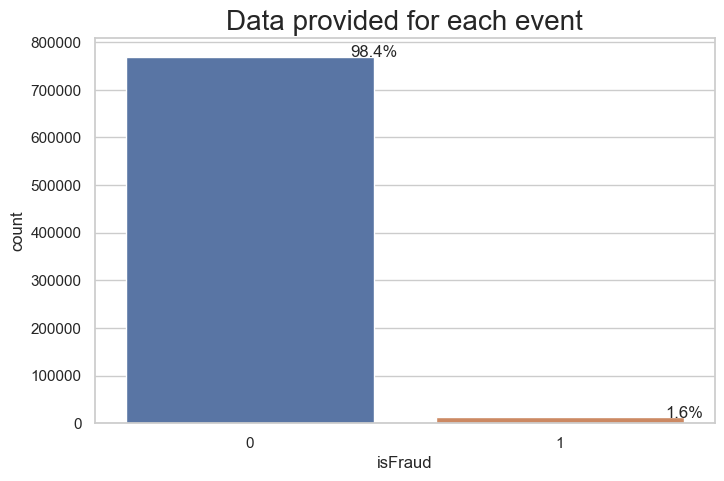

In [27]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
total = float(len(df_tran))
ax = sns.countplot(x="isFraud", data=df_tran)
plt.title('Data provided for each event', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

In [28]:
# We will do this a couple cells down
# X = df_tran.drop(columns= ['isFraud'])
# y = df_tran['isFraud']

# Before we do the train test split, we need to do SMOTE

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [29]:
print("Before OverSampling, counts of label 'True': {}".format(sum(df_tran['isFraud'] == 1)))
print("Before OverSampling, counts of label 'False': {} \n".format(sum(df_tran['isFraud'] == 0)))

Before OverSampling, counts of label 'True': 12127
Before OverSampling, counts of label 'False': 769776 



In [30]:
from imblearn.over_sampling import SMOTENC

X = df_tran.drop(columns= ['isFraud'])
y = df_tran['isFraud']

# sm = SMOTE(random_state = 2)
# X_res, y_res = sm.fit_resample(X, y.ravel())

# print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
# print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))
  
# print("After OverSampling, counts of label 'True': {}".format(sum(y_res == 1)))
# print("After OverSampling, counts of label 'False': {}".format(sum(y_res == 0)))

# Now we have a 50/50 split of fraud and non-fraud, now we can do the train test split.

In [31]:
import random

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.99, random_state=random.randrange(22))
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.99, random_state=random.randrange(78))
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.99, random_state=random.randrange(34))
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y, test_size=0.99, random_state=random.randrange(88))
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X, y, test_size=0.99, random_state=random.randrange(42))



In [32]:
X_train_1

,creditLimit,transactionAmount,posEntryMode,posConditionCode,currentBalance,cardPresent,expirationDateKeyInMatch,equalCVV,transactionDateTime_year,transactionDateTime_month,transactionDateTime_day,transactionDateTime_hour,transactionDateTime_minute,transactionDateTime_second,currentExpDate_year,currentExpDate_month,currentExpDate_day,accountOpenDate_year,accountOpenDate_month,accountOpenDate_day,dateOfLastAddressChange_year,dateOfLastAddressChange_month,dateOfLastAddressChange_day,acqCountry_CAN,acqCountry_MEX,acqCountry_PR,acqCountry_US,merchantCountryCode_CAN,merchantCountryCode_MEX,merchantCountryCode_PR,merchantCountryCode_US,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL
453771,15000,455.31,9.0,1.0,814.84,1,0,1,2016,1,4,22,13,58,2022,5,6,2015,12,3,2015,12,3,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9389,250,2.55,5.0,1.0,173.44,1,0,1,2016,1,5,6,23,13,2030,11,4,2013,11,1,2013,11,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
168085,2500,7.63,5.0,1.0,769.57,1,0,1,2016,4,2,3,2,10,2032,5,5,2014,5,3,2016,3,3,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
370750,500,166.63,2.0,1.0,77.49,0,0,1,2016,2,0,21,45,12,2025,4,1,2015,4,3,2015,4,3,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
493940,1000,30.74,5.0,8.0,490.44,0,0,1,2016,7,3,22,48,9,2029,2,3,2015,11,1,2015,11,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706837,15000,79.25,5.0,1.0,1740.43,1,0,1,2016,6,3,10,15,14,2021,10,4,2015,12,2,2015,12,2,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
559426,20000,41.31,5.0,1.0,584.71,1,0,1,2016,12,4,3,12,4,2022,5,6,2013,1,4,2013,1,4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
748599,500,112.20,2.0,8.0,80.30,0,0,1,2016,2,1,10,16,22,2022,5,6,2014,8,1,2014,8,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
287563,5000,123.49,90.0,1.0,4333.92,1,0,1,2016,2,1,18,46,8,2026,11,6,2015,11,6,2016,2,4,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [33]:
sm = SMOTE(random_state=27)
X_train_1, y_train_1 = sm.fit_resample(X_train_1, y_train_1)
X_train_2, y_train_2 = sm.fit_resample(X_train_2, y_train_2)
X_train_3, y_train_3 = sm.fit_resample(X_train_3, y_train_3)
X_train_4, y_train_4 = sm.fit_resample(X_train_4, y_train_4)
X_train_5, y_train_5 = sm.fit_resample(X_train_5, y_train_5)

print(len(y_train_1[y_train_1 == 1])/len(y_train_1), len(y_train_1))

0.5 15402


In [34]:
X_train, X_test, y_train, y_test = X_train_1, X_test_1, y_train_1, y_test_1

In [36]:
X_train

,creditLimit,transactionAmount,posEntryMode,posConditionCode,currentBalance,cardPresent,expirationDateKeyInMatch,equalCVV,transactionDateTime_year,transactionDateTime_month,transactionDateTime_day,transactionDateTime_hour,transactionDateTime_minute,transactionDateTime_second,currentExpDate_year,currentExpDate_month,currentExpDate_day,accountOpenDate_year,accountOpenDate_month,accountOpenDate_day,dateOfLastAddressChange_year,dateOfLastAddressChange_month,dateOfLastAddressChange_day,acqCountry_CAN,acqCountry_MEX,acqCountry_PR,acqCountry_US,merchantCountryCode_CAN,merchantCountryCode_MEX,merchantCountryCode_PR,merchantCountryCode_US,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL
0,10000,18.320000,9.000000,1.0,461.740000,1,0,1,2016,7,3,3,5,33,2023,9,4,2014,1,0,2016,1,3,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,5000,38.430000,9.000000,1.0,4245.020000,1,0,1,2016,5,6,6,15,56,2023,4,5,2012,10,3,2016,4,2,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,7500,159.120000,9.000000,1.0,6841.630000,1,0,1,2016,6,2,4,53,5,2030,8,3,2015,2,6,2015,2,6,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,20000,25.820000,2.000000,1.0,257.100000,1,0,1,2016,10,5,16,24,34,2026,11,6,2014,12,6,2014,12,6,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,10000,130.980000,2.000000,1.0,8846.020000,0,0,1,2016,12,4,5,44,11,2028,7,5,2015,9,5,2016,9,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15373,7500,262.850817,3.598648,8.0,3258.467976,0,0,1,2016,10,3,14,24,55,2029,8,3,2012,7,3,2012,6,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
15374,15000,135.020847,9.000000,1.0,222.362850,0,0,1,2016,9,1,2,49,51,2029,8,4,2014,12,3,2016,6,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
15375,5000,337.065479,2.000000,1.0,3393.102975,0,0,1,2016,8,5,9,19,43,2027,9,5,2014,7,4,2016,7,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
15376,9001,49.731814,6.205264,1.0,1523.436038,0,0,0,2016,6,0,3,27,32,2024,4,0,2011,10,3,2011,10,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [35]:
n_est = 5
max_depth = 5

# guess thresholds
# X = pd.DataFrame(X, columns=h)
# print("X:", X.shape)
# print("y:",y.shape)
X_train_guessed, thresholds, header, threshold_guess_time = compute_thresholds(X_train, y_train, n_est, max_depth)
X_test_guessed = cut(X_test.copy(), thresholds)
X_test_guessed = X_test_guessed[header]
print("train set column names == test set column names: {}".format(list(X_train_guessed.columns)==list(X_test_guessed.columns)))

# guess lower bound
start_time = time.perf_counter()
clf = GradientBoostingClassifier(n_estimators=n_est, max_depth=max_depth, random_state=42)
clf.fit(X_train_guessed, y_train.values.flatten())
warm_labels = clf.predict(X_train_guessed)
elapsed_time = time.perf_counter() - start_time
lb_time = elapsed_time

# save the labels from lower bound guesses as a tmp file and return the path to it.
labelsdir = pathlib.Path('./labels')
labelsdir.mkdir(exist_ok=True, parents=True)
labelpath = labelsdir / 'warm_label_fraud.tmp'
labelpath = str(labelpath)
pd.DataFrame(warm_labels, columns=["class_labels"]).to_csv(labelpath, header="class_labels",index=None)

/Users/quraiznajmi5253/opt/anaconda3/envs/Qn5253/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/quraiznajmi5253/opt/anaconda3/envs/Qn5253/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/quraiznajmi5253/opt/anaconda3/envs/Qn5253/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/quraiznajmi5253/opt/anaconda3/envs/Qn5253/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: Th

train set column names == test set column names: True


In [36]:
st = time.time()

# train GOSDT model
config = {
            "regularization": 0.001,
            "depth_budget": 5,
            "warm_LB": True,
            "reference_LB": True,
            "path_to_labels": labelpath,
            "time_limit": -1,
            "similar_support": False,
            "feature_transform": False,
            "allow_small_reg": True,
            
        }

model = GOSDT(config)

model.fit(pd.DataFrame(X_train_guessed), pd.DataFrame(y_train))
print("evaluate the model, extracting tree and scores", flush=True)

# get the results
train_acc = model.score(pd.DataFrame(X_train_guessed), pd.DataFrame(y_train))
n_leaves = model.leaves()
n_nodes = model.nodes()
# time = model.utime

# print("Model training time: {}".format(time))
print("Training accuracy: {}".format(train_acc))
print("# of leaves: {}".format(n_leaves))
print(model.tree)

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

gosdt reported successful execution
training completed. 0.000/0.000/102.895 (user, system, wall), mem=0 MB
bounds: [0.133979..0.133979] (0.000000) loss=0.119979, iterations=341988
evaluate the model, extracting tree and scores
Training accuracy: 0.8800207981281685
# of leaves: 14
if cardPresent<=0.5 = 1 and merchantCategoryCode_online_retail<=0.5 = 1 and posEntryMode<=2.002996325492859 = 1 and posEntryMode<=8.995759010314941 = 1 then:
    predicted class: 1
    misclassification penalty: 0.036
    complexity penalty: 0.001

else if cardPresent<=0.5 != 1 and merchantCategoryCode_online_retail<=0.5 = 1 and posEntryMode<=2.002996325492859 = 1 and posEntryMode<=8.995759010314941 = 1 then:
    predicted class: 0
    misclassification penalty: 0.003
    complexity penalty: 0.001

else if currentBalance<=12542.80517578125 = 1 and merchantCategoryCode_online_retail<=0.5 != 1 and posEntryMode<=2.002996325492859 = 1 and posEntryMode<=8.995759010314941 = 1 then:
    predicted class: 0
    misclas

In [37]:
test_score = model.score(X_test_guessed[:10000], y_test[:10000])
print(test_score)

0.8406


/var/folders/sn/1rkb9b6d6676rjdtm6y0sp880000gn/T/ipykernel_9719/1604864933.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  test_score = model.score(X_test_guessed[:10000], y_test[:10000])


In [38]:
y_test_pred = model.predict(X_test_guessed)

print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))

Accuracy: 0.8415029893396583
Recall: 0.2772268977585201
Precision: 0.028352777754105486
F1: 0.05144421078673923


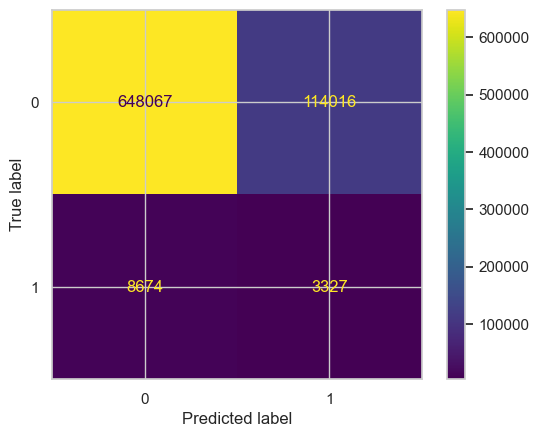

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [40]:
ncols = len(X_train.columns) - len(X_test.columns)
if ncols > 0:
    X_train.drop(columns=X_train.columns[-ncols:], axis=1, inplace=True)

## OCT

In [42]:
X_train_OCT, X_test_OCT, y_train_OCT, y_test_OCT = train_test_split(X, y, test_size=0.999, random_state=random.randrange(22))
X_train_OCT, y_train_OCT = sm.fit_resample(X_train_OCT, y_train_OCT)

In [43]:
# Reshaping for OCT
# This requires very small dataset, only adjust size for this (i.e. train_test_split of .999, for example)

X_train_OCT = X_train_OCT.to_numpy()
y_train_OCT = y_train_OCT.to_numpy()

X_test_OCT = X_test_OCT.to_numpy()
y_test_OCT = y_test_OCT.to_numpy()

In [44]:
st = time.time()

octree = miptree.optimalDecisionTreeClassifier(max_depth=5, min_samples_split=10, alpha=0.01, warmstart=True, timelimit=300, output=True)
octree.fit(X_train_OCT, y_train_OCT)

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Training data include 1532 instances, 53 features.
Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-23
Set parameter TimeLimit to value 300


/Users/quraiznajmi5253/Documents/Notebooks/Practicum/Best/Practicum-Project/tree/oct.py:180: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(y)[0][0]


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 296056 rows, 50953 columns and 10400196 nonzeros
Model fingerprint: 0x2a405487
Variable types: 159 continuous, 50794 integer (50794 binary)
Coefficient statistics:
  Matrix range     [2e-07, 2e+03]
  Objective range  [1e-03, 1e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]

User MIP start did not produce a new incumbent solution
Processed MIP start in 2.34 seconds (0.80 work units)

Presolve removed 0 rows and 93 columns (presolve time = 5s) ...
Presolve removed 0 rows and 93 columns (presolve time = 10s) ...
Presolve removed 32 rows and 125 columns (presolve time = 16s) ...
Presolve removed 32 rows and 125 columns (presolve time = 21s) ...
Presolve removed 32 rows and 125 columns (presolve time = 25s) ...
Presolve removed 32 rows and 125 columns (presolve time = 31s) ...
Presolve removed 7125 rows a

In [45]:
# Test accuracy
y_test_pred = octree.predict(X_test_OCT)


print("Accuracy:", accuracy_score(y_test_OCT, y_test_pred))
print("Recall:", recall_score(y_test_OCT, y_test_pred))
print("Precision:", precision_score(y_test_OCT, y_test_pred))
print("F1:", f1_score(y_test_OCT, y_test_pred))

Accuracy: 0.015505900486735747
Recall: 1.0
Precision: 0.015505900486735747
F1: 0.030538277481802344


In [46]:
# Train accuracy
y_train_pred = octree.predict(X_train_OCT)


print("Accuracy:", accuracy_score(y_train_OCT, y_train_pred))
print("Recall:", recall_score(y_train_OCT, y_train_pred))
print("Precision:", precision_score(y_train_OCT, y_train_pred))
print("F1:", f1_score(y_train_OCT, y_train_pred))

Accuracy: 0.5
Recall: 1.0
Precision: 0.5
F1: 0.6666666666666666


## LASSO

In [35]:
X_train

,creditLimit,transactionAmount,posEntryMode,posConditionCode,currentBalance,cardPresent,expirationDateKeyInMatch,equalCVV,transactionDateTime_year,transactionDateTime_month,transactionDateTime_day,transactionDateTime_hour,transactionDateTime_minute,transactionDateTime_second,currentExpDate_year,currentExpDate_month,currentExpDate_day,accountOpenDate_year,accountOpenDate_month,accountOpenDate_day,dateOfLastAddressChange_year,dateOfLastAddressChange_month,dateOfLastAddressChange_day,acqCountry_CAN,acqCountry_MEX,acqCountry_PR,acqCountry_US,merchantCountryCode_CAN,merchantCountryCode_MEX,merchantCountryCode_PR,merchantCountryCode_US,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL
0,15000,455.310000,9.000000,1.000000,814.840000,1,0,1,2016,1,4,22,13,58,2022,5,6,2015,12,3,2015,12,3,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,250,2.550000,5.000000,1.000000,173.440000,1,0,1,2016,1,5,6,23,13,2030,11,4,2013,11,1,2013,11,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2500,7.630000,5.000000,1.000000,769.570000,1,0,1,2016,4,2,3,2,10,2032,5,5,2014,5,3,2016,3,3,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,500,166.630000,2.000000,1.000000,77.490000,0,0,1,2016,2,0,21,45,12,2025,4,1,2015,4,3,2015,4,3,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1000,30.740000,5.000000,8.000000,490.440000,0,0,1,2016,7,3,22,48,9,2029,2,3,2015,11,1,2015,11,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15397,50000,253.786855,33.684787,5.566289,19356.479409,0,0,1,2016,2,5,8,28,37,2023,4,4,2014,6,1,2015,2,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
15398,15000,210.693910,8.304171,1.000000,13633.343004,0,0,1,2016,9,4,19,36,23,2030,4,3,2014,8,2,2016,8,5,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
15399,250,163.842886,9.000000,1.000000,123.595016,0,0,1,2016,9,4,14,51,2,2029,11,6,2015,6,6,2015,6,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
15400,20000,45.446421,5.202987,4.202987,6726.329046,0,0,1,2016,9,0,9,38,50,2026,6,2,2014,8,2,2016,7,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [36]:
st = time.time()

clf = LogisticRegression(random_state=0, max_iter=10000, penalty="l1", solver="saga").fit(X_train, y_train)

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 25.723124980926514 seconds


In [37]:
X_test.shape

(774084, 53)

In [38]:
# y_train_pred = clf.predict(X_train)
# print(accuracy_score(y_train, y_train_pred))

# Test accuracy
y_test_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_test_pred))

0.7100585982916583


In [39]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))

Accuracy: 0.7100585982916583
Recall: 0.5057873261720376
Precision: 0.02704628236069428
F1: 0.05134686183095437


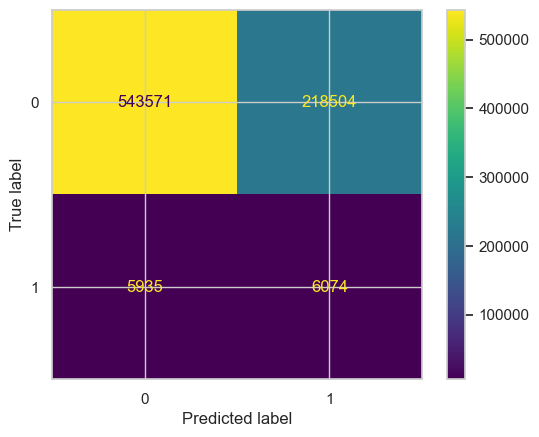

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Random Forest

In [41]:
st = time.time()

clf = RandomForestClassifier(n_estimators = 25, criterion = 'entropy', random_state =7)
clf.fit(X_train, y_train)

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 0.3739509582519531 seconds


In [42]:
y_test_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))

Accuracy: 0.9827538096640674
Recall: 0.0097426929802648
Precision: 0.07428571428571429
F1: 0.017226148409893994


## CART

In [43]:
st = time.time()

clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 0.12691020965576172 seconds


In [44]:
y_test_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))

Accuracy: 0.9560771182455651
Recall: 0.06903155966358565
Precision: 0.03505433633557444
F1: 0.04649727971282741


[Text(0.5452737862723215, 0.9807692307692307, 'X[5] <= 0.5\nentropy = 1.0\nsamples = 15402\nvalue = [7701, 7701]'),
 Text(0.24102376302083334, 0.9423076923076923, 'X[1] <= 53.135\nentropy = 0.95\nsamples = 11438\nvalue = [4222, 7216]'),
 Text(0.05714285714285714, 0.9038461538461539, 'X[3] <= 1.002\nentropy = 0.711\nsamples = 1994\nvalue = [1606, 388]'),
 Text(0.03428571428571429, 0.8653846153846154, 'X[0] <= 750.0\nentropy = 0.43\nsamples = 1432\nvalue = [1306, 126]'),
 Text(0.015238095238095238, 0.8269230769230769, 'X[19] <= 3.5\nentropy = 0.996\nsamples = 210\nvalue = [113, 97]'),
 Text(0.007619047619047619, 0.7884615384615384, 'X[1] <= 48.374\nentropy = 0.289\nsamples = 79\nvalue = [75, 4]'),
 Text(0.0038095238095238095, 0.75, 'entropy = 0.0\nsamples = 73\nvalue = [73, 0]'),
 Text(0.011428571428571429, 0.75, 'X[20] <= 2014.0\nentropy = 0.918\nsamples = 6\nvalue = [2, 4]'),
 Text(0.007619047619047619, 0.7115384615384616, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.01523809

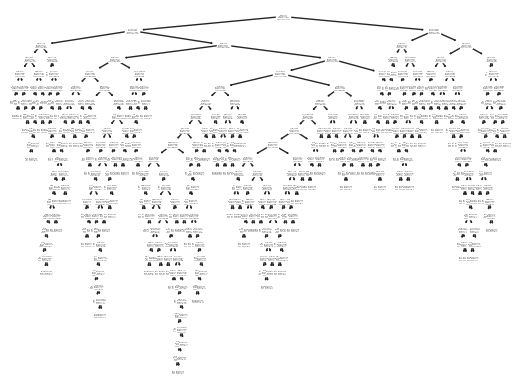

In [45]:
from sklearn import tree

tree.plot_tree(clf)

In [46]:
print(clf.tree_.node_count)

613


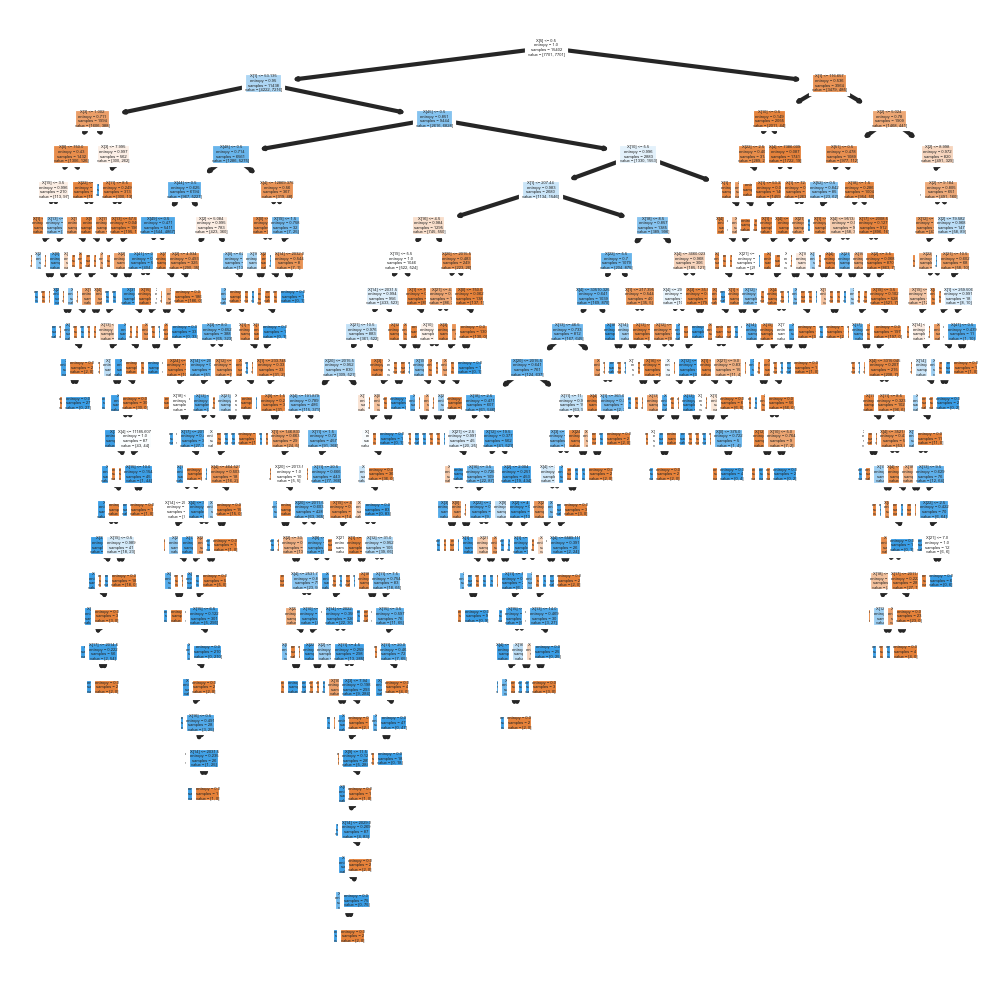

In [47]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf,
               filled = True);

In [48]:
fig.savefig('imagename.png')